In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir = '../portfolio/plots/'
datadir='../data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]



#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-02-01"
end_t="2014-02-08"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')

return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()
#risk_data = pd.HDFStore(datadir+'risk_model.h5')
#risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)
risk_model = cp.FullSigma(Sigma_hat)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for 

In [3]:
all_return_estimates={}
n_p1=returns.shape[1]
T=returns.shape[0]

for i,t in enumerate(returns.index[:-1]):
    all_return_estimates[(t,t)]= return_estimate.loc[t]
    tp1=returns.index[i+1]
    all_return_estimates[(t,tp1)]=return_estimate.loc[tp1]
    
returns_forecast = cp.MPOReturnsForecast(all_return_estimates)
results_MPO={}

## MPO Coarse search 

In [4]:
import cvxpy as cvx
policies={}
gamma_risks_coarse=[.1,.3,1, 3,10,30,100,300,1000]
gamma_tcosts_coarse=[1., 2., 5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=True))})

In [5]:
result_df_coarse=pd.DataFrame()
for k in results_MPO:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[38.955876925182238, 38.217142298600116, 35.592408216687076, 26.861065625439366, 14.516285372291488, 6.3975890472508077, 2.4279372480386896, 0.97868995941591674, 0.37117221364461161] [39.56561117405082, 38.68160335383527, 37.935943045541634, 30.00780870428411, 18.057213673285695, 9.970578551917638, 4.467805958693499, 1.888452869124091, 0.6225981237288604]
[38.728776643881176, 36.820595900738439, 29.8523695811114, 20.84454038562356, 11.126340082767587, 4.7767003944792261, 1.8193700376795616, 0.76096638978234077, 0.31949199058961941] [43.19932335324507, 41.51901421224391, 35.971693783520344, 27.06041967540814, 15.311033892212398, 8.424591281255458, 3.6826359819956997, 1.5345413752995305, 0.5043819427837468]
[31.53878820093637, 27.414743905577431, 21.408120391898194, 12.252217274505835, 6.0761992219882028, 3.0089089274162237, 1.2505558785438933, 0.54904099816391005, 0.26354806801972713] [27.201858355977635, 22.13082383719843, 16.348463374033653, 11.512472247181998, 8.080636579881363, 4.66

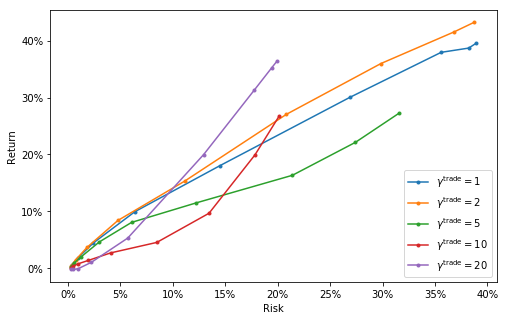

In [6]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

### Fine search

In [7]:
policies = {}

gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine: 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=True))})

In [8]:
result_df_fine=pd.DataFrame()
for k in results_MPO:
    if k[0] in gamma_risks_fine and k[1] in gamma_tcosts_fine:
        result_df_fine.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_fine.loc[sorted(result_df_fine.index), sorted(result_df_fine.columns)]

[30.693232612521598, 27.745455990319631, 21.789750823505315, 14.024020252576188, 7.2547133001284845, 3.4299138375039528, 1.3677461728156799, 0.58754425968408597, 0.27218255921519202] [29.055938371371774, 23.6432716489613, 17.325758790158055, 14.584256355422855, 10.553842379586971, 5.540273428570774, 2.441990736743003, 1.060182779953327, 0.3421102037677261]
[31.538788186710509, 27.414743916500814, 21.408120387421018, 12.252217274579305, 6.0761992214334564, 3.0089089306831598, 1.2505558792810054, 0.54904099657516781, 0.26354806804644104] [27.201858358521243, 22.130823849358354, 16.348463382095883, 11.512472252281551, 8.080636578897062, 4.661378392605252, 2.011593114704728, 0.8782670099457133, 0.28052121446296224]
[32.206378716877005, 27.991120442423419, 20.183253673831075, 11.175352788155308, 5.2638933827523608, 2.6638813217388315, 1.1585667509746098, 0.52455728205680408, 0.25934044007556506] [26.999008606830166, 22.095407510814837, 13.043585541329765, 8.479338538377034, 6.11318616637910

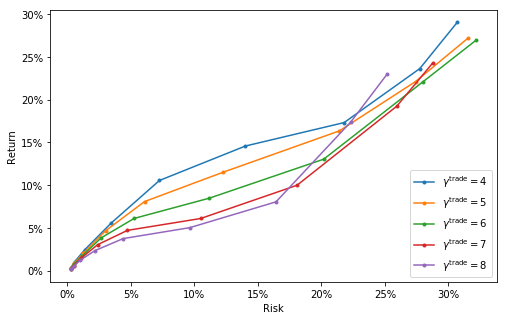

In [9]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

# MPO Pareto search 

In [10]:
results_pareto={}

In [11]:
policies={}
#gamma_risks_pareto=[int(round(el)) for el in np.logspace(0,3,13)]
gamma_risks_pareto=[1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[7,8,9,10,11,12]
gamma_holdings=[.1,1.,10.]#, 100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = cp.MultiPeriodOpt(
                return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, 
                                 gamma_holding*optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
#                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,
                                                                                end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [12]:
(start_t, end_t)

('2012-02-01', '2014-02-08')

In [13]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]

table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'mpo_pareto_results.csv', float_format='%g')

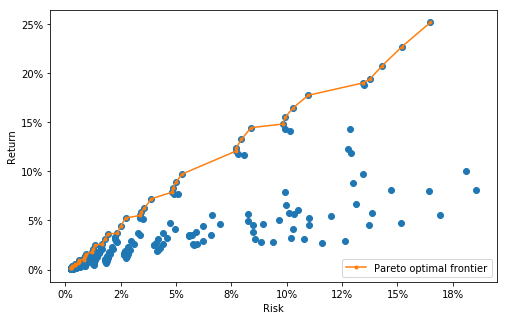

In [14]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'mpo_pareto.png')

In [15]:
xlim=20
ylim=30
tableprint=table[table.is_pareto]
tableprint=tableprint[tableprint.Risk <= xlim]
tableprint=tableprint[tableprint.Return <= ylim]
del tableprint['is_pareto']
tableprint.Risk=tableprint.Risk.apply(lambda x: '%.2f%%'%x)
tableprint.Return=tableprint.Return.apply(lambda x: '%.2f%%'%x)
print(tableprint.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                   1000 &                        7 &                     10 &   0.18\% &   0.24\% \\
                   1000 &                        7 &                      1 &   0.18\% &   0.26\% \\
                   1000 &                        7 &                    0.1 &   0.18\% &   0.26\% \\
                    562 &                        8 &                     10 &   0.28\% &   0.31\% \\
                    562 &                        7 &                     10 &   0.34\% &   0.32\% \\
                    316 &                        9 &                     10 &   0.43\% &   0.42\% \\
                    316 &                        8 &                     10 &   0.50\% &   0.43\% \\
                    316 &                        7 &                     10 &   0.59\% &   0.44\% \\
                    178 &                       10 &

In [16]:
table

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk,is_pareto
0,1,7,0.1,8.077134,18.558640,False
1,1,7,1,9.991040,18.083613,False
2,1,8,0.1,5.538247,16.908411,False
3,1,7,10,25.163359,16.485316,True
4,1,8,1,8.049201,16.427796,False
5,1,8,10,22.705886,15.204110,True
6,1,9,0.1,4.751088,15.138176,False
7,1,9,1,8.072108,14.705594,False
8,1,9,10,20.750850,14.303065,True
9,1,10,0.1,5.726325,13.864890,False
